In [1]:
import os
import sys
from dotenv import load_dotenv
import yaml

load_dotenv()
DVUTILS_LOCAL_CLONE_PATH = os.environ.get("DVUTILS_LOCAL_CLONE_PATH")
sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)

from utils_io import *

Info: Found credentials at: /Users/lelias/Library/CloudStorage/Box-Box/dvutils-creds-lelias.json


## Define Parameters

In [2]:
## Set the PCA Layers configuration file: PCA Geographies and PCA Types
yaml_file = 'pca-layers.yml'

## Create ArcGIS Client
client = create_arcgis_client()

Admin ArcGIS client created


## Create Functions

In [3]:
def simplify_geoms(gdf):
    """Simplify and clean Geometries by applying dissolve, explode,
    simplify and repair_geometry functions
    """
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")
    ## Convert Multipart features to Single part
    gdf = gdf.dissolve(by=None).reset_index(drop=True)
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
    ## Repair Geometries
    gdf = repair_geometry(gdf.query("geometry.notnull()"))
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")

    return gdf


def create_footprint(gdf, flag_name, dist=False):
    """Create Area Footprint from GeoDataframe and assign Flag Name
    to Column
    """
    ## Simplify Dataset
    gdf = gdf[["geometry"]].copy()
    gdf = simplify_geoms(gdf)
    ## Set Area Name
    gdf[flag_name] = 1

    return gdf


def create_footprints_for_dict(input_dict, flag_name):
    """Iterate through Dictionary object and create area footprints
    by applying the create_footprint function
    """
    for k, v in input_dict.items():
        print(f"Creating Footprint for dataset: {k}")
        try:
            data_key = "data" if "data" in v else "data_load"
            print(f"Using: {data_key}")
            v["footprint"] = create_footprint(v[data_key], v[flag_name])
            v["footprint"].plot()
            print("Creation of Footprint completed\n")
        except:
            print("Creation of Footprint failed!\n")

In [8]:
def assign_footprint(
                gdf_base,
                gdf_over,
                flag_name,
                gdf_base_id="gdf_id",
                return_share=True
                ):
    """Given an Input Geodataframe, runs Spatial Overlay
    to p10 Parcels and returns Parcel Assignment crosswalk
    """
    ## Check for gdf_id or create
    if (gdf_base_id == 'gdf_id') and (not gdf_base_id in gdf_base.columns):
        print('Creating gdf_id')
        gdf_base.reset_index(drop=True, inplace=True)
        gdf_base['gdf_id'] = gdf_base.index
    ## Create Base GeoDataframe to Input GeoDataframe correspondence
    print('Creating Base GeoDataframe to Input GeoDataframe correspondence')
    gdf_over_corresp = geo_assign_fields(
        id_df=gdf_base[[gdf_base_id, 'geometry']],
        id_field=gdf_base_id,
        overlay_df=gdf_over,
        overlay_fields=[flag_name],
        return_intersection_area=return_share,
    )
    ## Merge p10 Parcels GeoDataframe to Input GeoDataframe using correspondence,
    ## return Dataframe
    gdf_base_fields = [i for i in gdf_base.columns if i != "geometry"]
    if return_share:
        if (not 'area_sq_m' in gdf_base.columns):
            print('Creating area_sq_m')
            gdf_base['area_sq_m'] = gdf_base.geometry.area
            gdf_base_fields.append("area_sq_m")
    base_over = pd.merge(gdf_base[gdf_base_fields], gdf_over_corresp, on=gdf_base_id, how="left")
    if return_share:
        intersect_area_col = f"{flag_name}_intersect_sq_m"
        share_pct_col = f"{flag_name}_share_pct"
        base_over.rename(columns={"intersection_sq_m": intersect_area_col}, inplace=True)
        base_over[share_pct_col] = base_over[intersect_area_col] / base_over["area_sq_m"]

    return base_over


def assign_footprints_from_dictionary(base_dict, overlay_dict, flag_col):
    """
    Assigns a footprint flag to base_dict for each item in the overlay_dict, based on flag_name.
    """
    for pca_type, type_att in overlay_dict.items():
        try:
            print(f'Dataset {pca_type}: Starting Assignment of Footprint')
            flag_name = type_att[flag_col]
            type_att['assignment'] = assign_footprint(
                gdf_base=base_dict['data_load'],
                gdf_over=type_att['footprint'],
                flag_name = flag_name
                )
            print(f'Dataset {pca_type}: Assignment of Footprint complete\n')
        except:
            print(f'Dataset {pca_type}: Assignment of Footprint failed!\n')
            pass

## Load PCA Layers definitions from YAML

In [4]:
## Load PCA Geographies from YAML
with open(yaml_file, 'r') as file:
    pca_geo = yaml.safe_load(file)['pca_geo']
print(pca_geo)

## Load PCA Types from YAML
with open(yaml_file, 'r') as file:
    pca_types = yaml.safe_load(file)['pca_types']
print([i for i in pca_types.keys()])

## Load UGB from YAML
with open(yaml_file, 'r') as file:
    ugb = yaml.safe_load(file)['ugb']
print(ugb)

{'name': 'PCA Geographies', 'agol': 'https://www.arcgis.com/home/item.html?id=8f4a98b1bb32402db22ba7379ea062a9', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/PBA50_PCA_Polygons/FeatureServer/2'}
['natural_land', 'working_land', 'urban_greening', 'recreation', 'climate_adaptation']
{'flag': 'ugb', 'name': 'EN4_Urban_Growth_Boundary', 'agol': 'https://mtc.maps.arcgis.com/home/item.html?id=9e16c1e49bcf40f5817d26a7684e1ad4', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/EN4_Urban_Growth_Boundary/FeatureServer/0'}


## Load PCA Layers from AGOL Datasets

Breaking feature service layer IDs into 1 chunks


<Axes: >

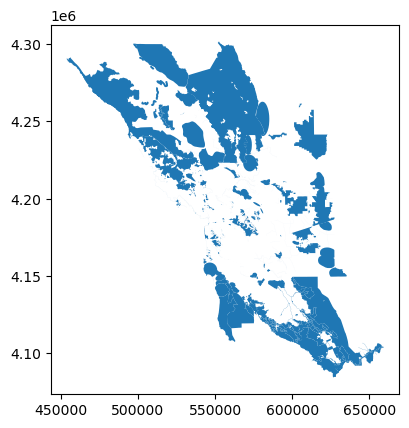

In [5]:
## Load PCA Geographies
## Pull GeoTable from AGOL as GeoDataframe
pca_geo['data_load'] = pull_geotable_agol(pca_geo['url'], client=client)

pca_geo['data'] = pca_geo['data_load'].copy()
pca_geo['data'].reset_index(drop=True, inplace=True)
pca_geo['data']['gdf_id'] = 1 + pca_geo['data'].index

pca_geo['data'].plot()

In [ ]:
## Load PCA types
for i in pca_types.keys():
    print(i)
    print(pca_types[i]['url'])
    try:
        print(f"Loading data for {i}")
        ## Pull GeoTable from AGOL as GeoDataframe
        pca_types[i]['data_load'] = pull_geotable_agol(pca_types[i]['url'], client=client)
        pca_types[i]['data_load'].plot()
        print("Data loaded successfully\n")
    except:
        print(f"Failed to load data for {i}!\n")


Breaking feature service layer IDs into 6 chunks


<Axes: >

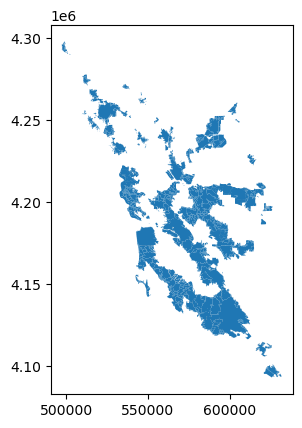

In [6]:
## Load UGB
## Pull GeoTable from AGOL as GeoDataframe
ugb['data_load'] = pull_geotable_agol(ugb['url'], client=client)

ugb['data'] = ugb['data_load'].copy()
ugb['data'].reset_index(drop=True, inplace=True)
ugb['data']['ugb_geo_id'] = 1 + ugb['data'].index

ugb['data'].plot()

## Flag #1 PCA Geographies to PCA Types

### Create Footprints for PCA Types

In [ ]:
create_footprints_for_dict(pca_types, 'flag')

### Assign PCA Type Footprints to PCA Geographies

In [ ]:
assign_footprints_from_dictionary(pca_geo, pca_types, 'flag')

In [ ]:
for pca_type, type_att in pca_types.items():
    try:
        print('Displaying Assignment of Footprint for PCA Type:', pca_type)
        display(type_att['assignment'].sample(3))
    except:
        print(f'Display of Assignment of Footprint for PCA Type {pca_type} failed!')

## Integrate Assignments of PCA Types to single Assignment file

In [ ]:
data_key = "data" if "data" in pca_geo.keys() else "data_load"
pca_geo['assignment'] = pca_geo[data_key].drop(columns=['geometry'])
## Merge PCA Geographies to PCA Types Assignments 
for pca_type, type_att in pca_types.items():
    try:
        flag = type_att['flag']
        cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
        pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            type_att['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
        print(f'Assignment of Footprint for PCA Type {pca_type} completed\n')
    except:
        print(f'Assignment of Footprint for PCA Type {pca_type} failed!\n')

## Flag #2 PCA to UGB

### Create Footprint for UGB

Creating Footprint for dataset: EN4_Urban_Growth_Boundary
Using: data
GDF Geometry Types: ['MultiPolygon' 'Polygon' None]
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed



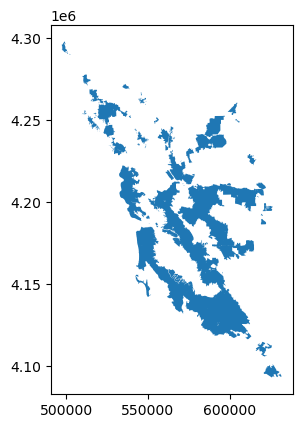

In [7]:
print(f"Creating Footprint for dataset: {ugb['name']}")
data_key = "data" if "data" in ugb.keys() else "data_load"
print(f"Using: {data_key}")
ugb["footprint"] = create_footprint(ugb[data_key], ugb['flag'])
ugb["footprint"].plot()
print("Creation of Footprint completed\n")

### Assign UGB Footprint to PCA Geographies

In [15]:
print(f"Dataset {ugb['name']}: Starting Assignment of Footprint")
data_key = "data" if "data" in pca_geo.keys() else "data_load"
print(f"Using: {data_key}")
flag_name = ugb['flag']
ugb['assignment'] = assign_footprint(
    gdf_base=pca_geo[data_key],
    gdf_over=ugb['footprint'],
    flag_name = flag_name
    )
print(f"Dataset {ugb['name']}: Assignment of Footprint complete\n")

Dataset EN4_Urban_Growth_Boundary: Starting Assignment of Footprint
Using: data
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', 'ugb']
took 1.0322 seconds
Creating area_sq_m
Dataset EN4_Urban_Growth_Boundary: Assignment of Footprint complete



In [32]:
ugb['assignment'].sample(3).T

,121,50,109
OBJECTID,122,51,110
fipco,6085,6013,6081
joinkey,SC42,CC3,SM18
lead,Santa Clara Valley Open Space Authority,City of San Ramon,San Mateo County Parks Department
name,Los Gatos Creek Park,Big Canyon Preserve,San Bruno Mountain and Surrounding Area
acres,110.609441,100.844591,3257.325347
typenl,1,1,1
typeal,0,0,1
typeug,1,0,1
typerr,1,0,1


## Integrate Assignments of UGB to single Assignment file

In [34]:
## Assign UGB Footprint to PCA Geographies
## Assignment #1 should be run first
flag = ugb['flag']
cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            ugb['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
print(f"Assignment of Footprint for {ugb['flag']} completed")

KeyError: 'assignment'

### Check samples from Integrated Assignments table

In [ ]:
pca_geo['assignment'].sample(3).T

## Export Integrated Assignments #1 and #2 as Table

In [ ]:
col_order = ['gdf_id'] + [c for c in pca_geo['assignment'].columns if c != 'gdf_id']
pca_geo['assignment'][col_order].fillna(0).to_csv('pca_type_assignment.csv', index=False)

## Flag #3 PCA to PCA

In [ ]:
def overlay_surface_percentage_matrix(gdf, id_column='gdf_id', how='intersection'):
    """
    Creates a matrix of overlay surface percentages for each pair of features in the GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The input GeoDataFrame.
    id_column (str): The name of the column with unique numeric identifiers.
    how (str): The type of overlay operation (default is 'intersection').
    
    Returns:
    matrix (DataFrame): A DataFrame where each cell (i, j) contains the percentage of the surface area of feature i
                        that is overlapped by feature j.
    """
    if id_column not in gdf.columns:
        raise ValueError(f"GeoDataFrame must contain a column named '{id_column}'")

    ids = gdf[id_column].values
    matrix = pd.DataFrame(index=ids, columns=ids, dtype=float)
    
    for i, id_i in enumerate(ids):
        print(f"Processing feature {i + 1} of {len(ids)}")
        feature_i = gdf[gdf[id_column] == id_i]
        for j, id_j in enumerate(ids):
            if id_i == id_j:
                # The percentage of overlay with itself is 100%
                matrix.at[id_i, id_j] = 100.0
            else:
                feature_j = gdf[gdf[id_column] == id_j]
                overlay_result = gpd.overlay(feature_i, feature_j, how=how, keep_geom_type=True)
                
                if not overlay_result.empty:
                    # Calculate the percentage of the surface area of feature i that is overlapped by feature j
                    area_i = feature_i.geometry.area.values[0]
                    area_overlay = overlay_result.geometry.area.sum()
                    percentage_overlay = (area_overlay / area_i) * 100
                else:
                    percentage_overlay = 0.0
                
                matrix.at[id_i, id_j] = percentage_overlay
    
    return matrix

In [ ]:
# Perform the overlay matrix operation
pca_geo['matrix'] = overlay_surface_percentage_matrix(pca_geo['data'], id_column='gdf_id', how='intersection')


### Export PCA to PCA Overlay Matrix

In [ ]:
pca_geo['matrix'].fillna(0).to_csv('pca_matrix.csv', index=True)